🧭 Shape: (799, 20)
📋 Columns: ['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'marketcap', 'fundamental_group', 'close_price', 'high_price', 'low_price', 'open_price', 'value', 'ema5', 'ema15', 'ema35', 'ema89', 'ema200', 'rsi', 'trend_grade', 'quadrant']
  symbol      eps     pe   pbv  percentyield      marketcap fundamental_group  \
0   PPPM  0.02000   0.00  0.70          0.00  105500.001572                 D   
1   TPCH  0.24112   7.90  0.34         13.91  401575.987864                 A   
2   POLY  0.27632  12.89  2.42          6.38  152320.004272                 A   
3   VCOM  0.21428   7.85  1.48         10.79  303722.809988                 A   
4    NVD -0.00942  38.87  0.32          0.00    4186.000121                 E   

   close_price  high_price  low_price  open_price  value      ema5     ema15  \
0         0.40        0.43       0.39        0.42      0  0.405345  0.413705   
1         2.84        2.90       2.84        2.86      0  2.844297  2.849749   
2         6.80    

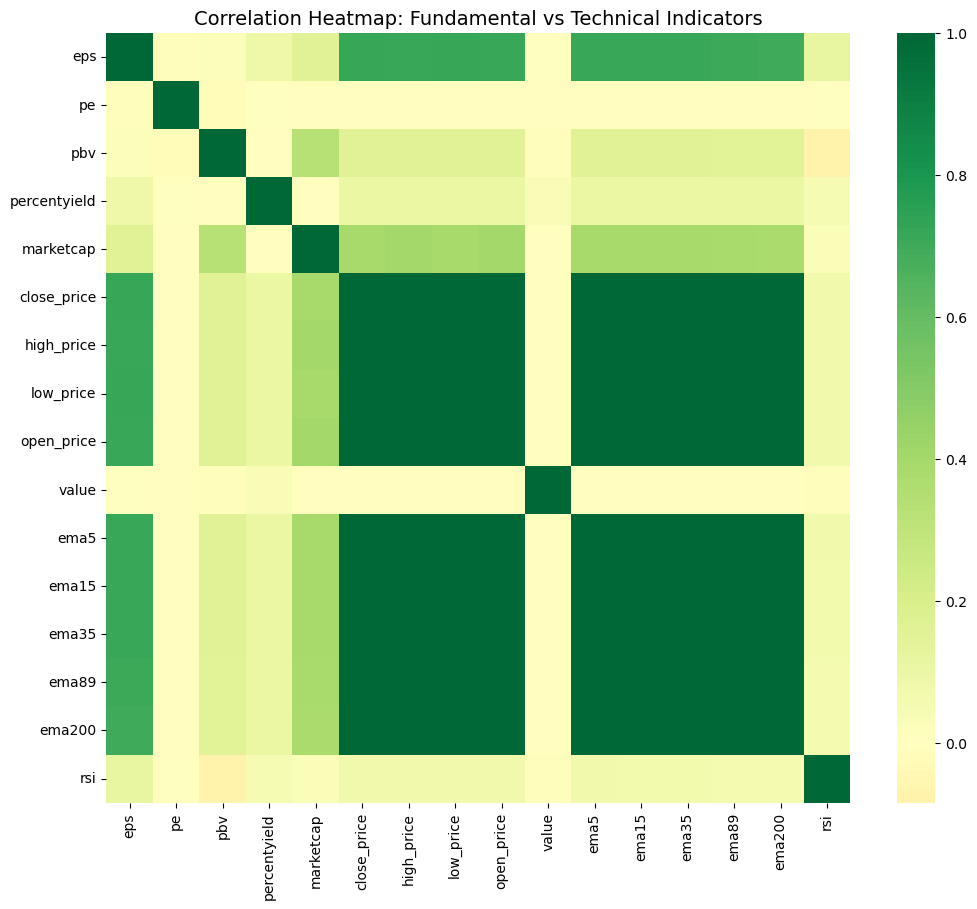


Dark green (~1) → Strong positive correlation
Dark red (~–1) → Strong negative correlation
White (~0) → Weak or no correlation



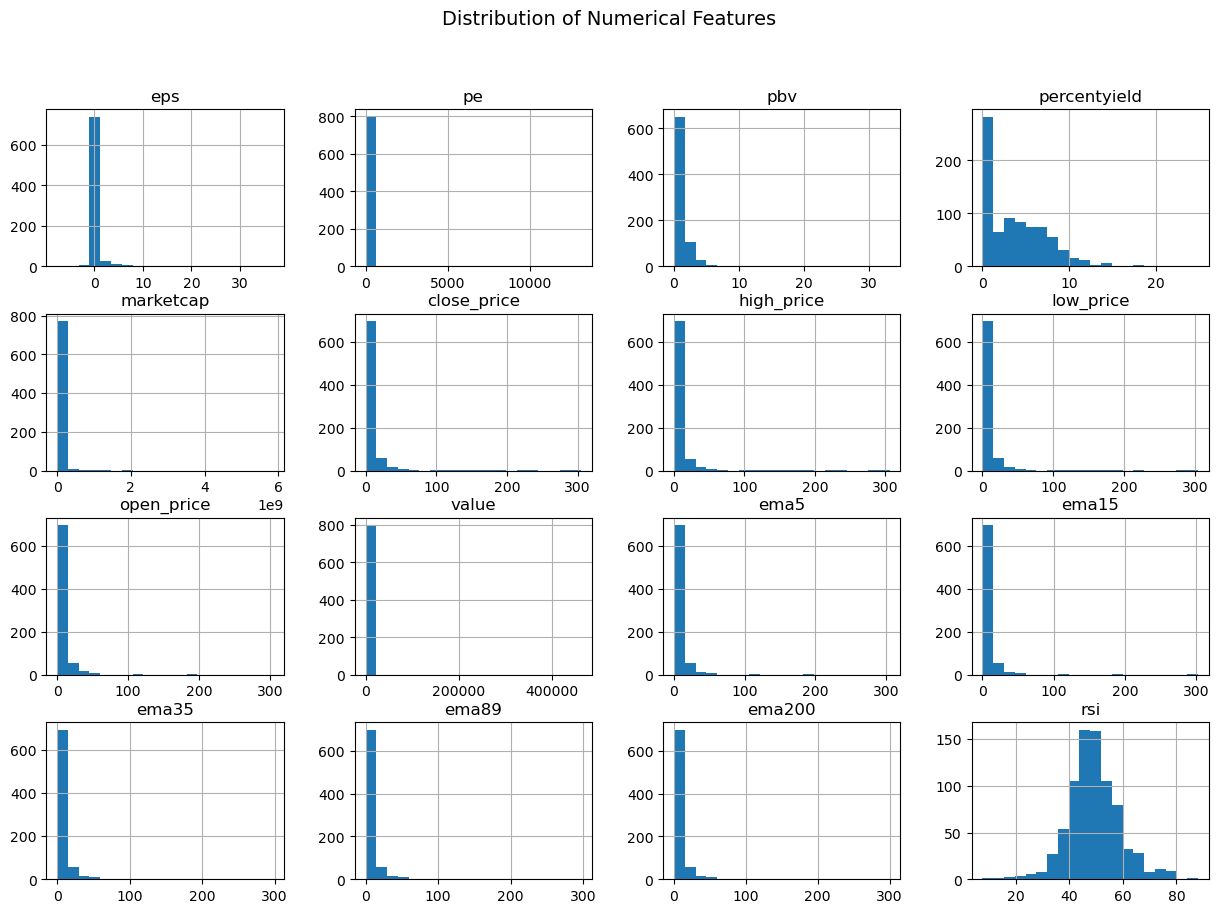

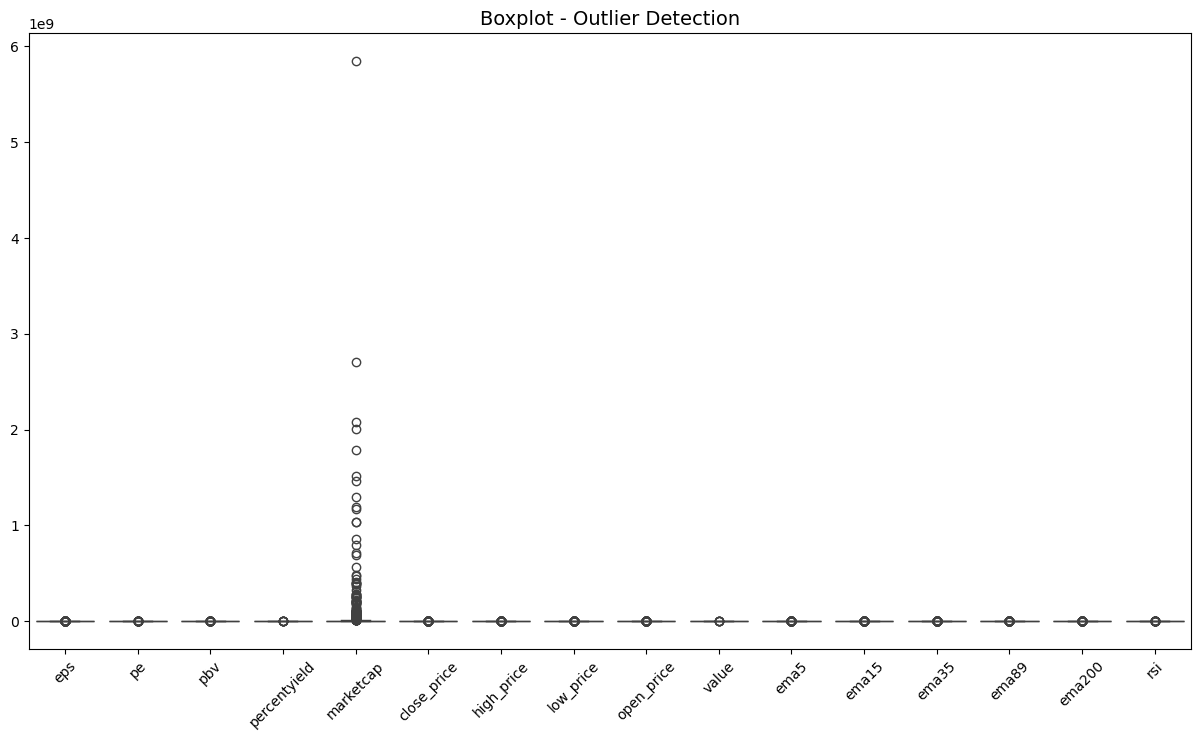

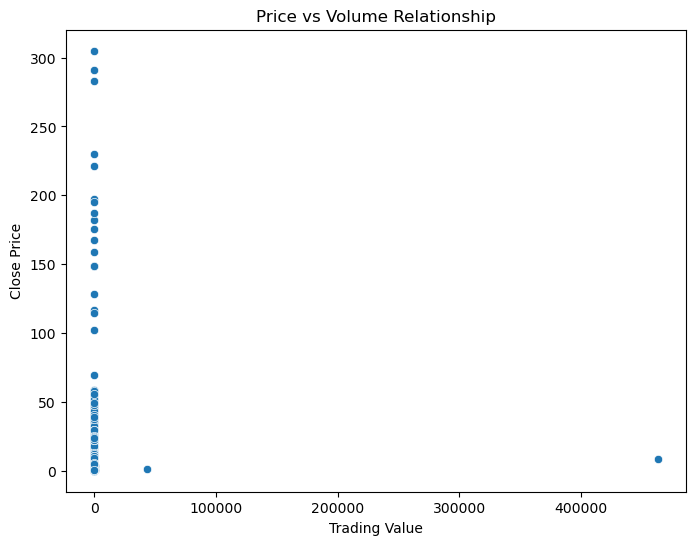

eps มี Outliers 13 จุด
pe มี Outliers 1 จุด
rsi มี Outliers 7 จุด
   rolling_mean_30  volatility_7d  volume_to_mcap
0              NaN            NaN             0.0
1              NaN            NaN             0.0
2              NaN            NaN             0.0
3              NaN            NaN             0.0
4              NaN            NaN             0.0

✅ Descriptive Statistics → สำรวจข้อมูลพื้นฐานและการกระจาย
✅ Correlation Analysis → ตรวจสอบความสัมพันธ์ระหว่างฟีเจอร์
✅ Visualization → แสดงผลแบบ Histogram / Boxplot / Scatter / Candlestick
✅ Outlier Detection → จัดการค่า Outlier ด้วย Z-score
✅ Feature Engineering → สร้างฟีเจอร์ใหม่: rolling_mean_30, volatility_7d, volume_to_mcap



In [1]:
# ============================================================
# 🔍 Exploratory Data Analysis (EDA) for Stock Quadrant Project
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import mplfinance as mpf
from scipy import stats

# -----------------------------
# ✅ 1. Load Dataset
# -----------------------------
df = pd.read_excel("stock_all_data.xlsx")

print("🧭 Shape:", df.shape)
print("📋 Columns:", df.columns.tolist())
print(df.head())

# ============================================================
# ✅ 1. Descriptive Statistics
# ============================================================

# คำนวณค่าเฉลี่ย, มัธยฐาน, ค่าต่ำสุด, ค่าสูงสุด และ SD
desc = df.describe().T
desc["median"] = df.median(numeric_only=True)
desc["skewness"] = df.skew(numeric_only=True)
desc["kurtosis"] = df.kurtosis(numeric_only=True)
print(desc)

# ============================================================
# ✅ 2. Correlation Analysis
# ============================================================

# เลือกเฉพาะคอลัมน์ตัวเลข
num_cols = df.select_dtypes(include=[np.number])

# คำนวณ correlation matrix
corr = num_cols.corr()

# 🔸 Heatmap (Seaborn)
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="RdYlGn", center=0)
plt.title("Correlation Heatmap: Fundamental vs Technical Indicators", fontsize=14)
plt.show()

# 🔸 Interactive Correlation (Plotly)
fig = px.imshow(
    corr,
    text_auto=".2f",
    color_continuous_scale="RdYlGn",
    title="Interactive Correlation Matrix"
)
fig.show()

# 🧩 Interpretation
print("""
Dark green (~1) → Strong positive correlation
Dark red (~–1) → Strong negative correlation
White (~0) → Weak or no correlation
""")

# ============================================================
# ✅ 3. Data Visualization
# ============================================================

# 🎯 Histogram Distribution
num_cols.hist(bins=20, figsize=(15,10))
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

# 🎯 Boxplot (ตรวจสอบ Outliers)
plt.figure(figsize=(15,8))
sns.boxplot(data=num_cols)
plt.title("Boxplot - Outlier Detection", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 🎯 Scatter Plot: Volume vs Price
if "value" in df.columns and "close_price" in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df["value"], y=df["close_price"])
    plt.title("Price vs Volume Relationship")
    plt.xlabel("Trading Value")
    plt.ylabel("Close Price")
    plt.show()

# 🎯 Candlestick Chart (ใช้กรณีมีคอลัมน์: time, open_price, high_price, low_price, close_price)
if all(col in df.columns for col in ["time","open_price","high_price","low_price","close_price"]):
    df_candle = df.copy()
    df_candle["time"] = pd.to_datetime(df_candle["time"])
    df_candle = df_candle.set_index("time")

    mpf.plot(
        df_candle.tail(60),
        type='candle',
        style='yahoo',
        title='Candlestick Chart (Last 60 days)',
        volume=True
    )

# ============================================================
# ✅ 4. Outlier Detection and Cleaning
# ============================================================

# ใช้ Z-score ตรวจหาค่า Outlier
cols_check = ["eps", "pe", "rsi"]
for col in cols_check:
    if col in df.columns:
        z = np.abs(stats.zscore(df[col].dropna()))
        outliers = np.where(z > 3)[0]
        print(f"{col} มี Outliers {len(outliers)} จุด")

        # การจัดการ Outlier: Capping ที่ ±3 SD
        mean, std = df[col].mean(), df[col].std()
        df[col] = np.clip(df[col], mean - 3*std, mean + 3*std)

# ลบข้อมูลซ้ำและจัดรูปแบบเวลา
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"])
df = df.drop_duplicates()

# ============================================================
# ✅ 5. Feature Engineering (from EDA Findings)
# ============================================================

# 🔹 Rolling Mean (30-day Moving Average)
if "close_price" in df.columns:
    df["rolling_mean_30"] = df["close_price"].rolling(window=30).mean()

# 🔹 Volatility Indicator (ค่า std ของการเปลี่ยนแปลงรายวัน)
if "close_price" in df.columns:
    df["daily_return"] = df["close_price"].pct_change()
    df["volatility_7d"] = df["daily_return"].rolling(window=7).std()

# 🔹 Volume-to-MarketCap Ratio
if "marketcap" in df.columns and "value" in df.columns:
    df["volume_to_mcap"] = df["value"] / df["marketcap"]

# แสดงฟีเจอร์ใหม่
print(df[["rolling_mean_30","volatility_7d","volume_to_mcap"]].head())

# ============================================================
# ✅ Summary
# ============================================================
print("""
✅ Descriptive Statistics → สำรวจข้อมูลพื้นฐานและการกระจาย
✅ Correlation Analysis → ตรวจสอบความสัมพันธ์ระหว่างฟีเจอร์
✅ Visualization → แสดงผลแบบ Histogram / Boxplot / Scatter / Candlestick
✅ Outlier Detection → จัดการค่า Outlier ด้วย Z-score
✅ Feature Engineering → สร้างฟีเจอร์ใหม่: rolling_mean_30, volatility_7d, volume_to_mcap
""")
